# **Introduction**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

data = np.load('diabetes_data.npy', allow_pickle = True).item()

In [3]:
X_test = list(data.values())[0]
X_train = list(data.values())[1]
Y_train = list(data.values())[2]
Y_test = list(data.values())[3]

# **Exercise 13**

In [4]:
def CrossValidationKRR(X, Y, m, l):
    ''' 
    function to conduct five-fold cross validation using kernel ridge regression

    X, Y: training data
    m: mu (parameter in Gaussian kernel)
    l: lambda (regularization parameter)

    final_loss: average loss across all folds
    '''

    n = X.shape[0]
    ind_fold = n/5
    loss = []

    for i in range(1,6): # 5-fold cross validation
      loss_fold = 0

      ind_val = np.arange((i-1)*ind_fold, i*ind_fold).astype(int)
      ind_train = np.array([ind for ind in range(n) if ind not in ind_val]).astype(int)

      Xval, Xtrain = X[ind_val], X[ind_train]
      Yval, Ytrain = Y[ind_val,:], X[ind_train,:]

      n_fold = Xtrain.shape[0]

      K = np.zeros([n_fold, n_fold])

      # compute Kernel matrix
      for ii in range(n_fold):
        for jj in range(n_fold):
          K[ii, jj] = GaussianKernel(Xtrain[ii], Xtrain[jj], m)

      # compute alpha
      a = np.linalg.solve(K + n_fold*l*np.eye(n_fold), Ytrain)

      for iii in range(Xval.shape[0]):
        pred = predict(Xval[iii], Xtrain, a, m)
        loss_fold += zero_one_Loss(Yval[iii], pred)

    loss.append(loss_fold)
    final_loss = np.sum(loss) / n
    return final_loss


# Additional functions:

def GaussianKernel(x1, x2, mu):
  return np.exp(-mu * (np.linalg.norm(x1-x2)**2))

def predict(x, Xtrain, alpha, mu):
  sum = 0
  for i in range(Xtrain.shape[0]):
    sum += alpha[i]*GaussianKernel(Xtrain[i], x, mu)
  return np.sign(sum)

def zero_one_Loss(y, pred):
  return 1/2*np.absolute(y-np.sign(pred))

In [5]:
mu_range = [10e-4, 10e-3, 10e-2, 10e-1]
lmbd_range = [10e-4, 10e-3, 10e-2, 10e-1]

CVErrors = np.zeros([len(mu_range), len(lmbd_range)])

for i in range(len(mu_range)):
  for j in range(len(lmbd_range)):
    CVErrors[i, j] = CrossValidationKRR(X_train, Y_train, mu_range[i], lmbd_range[j])

print(CVErrors)

[[0.648 0.612 0.68  0.74 ]
 [0.68  0.644 0.62  0.692]
 [0.672 0.672 0.644 0.64 ]
 [0.676 0.672 0.672 0.676]]


Hence, the best parameters are mu = 10e-4, lambda = 10e-3.


In [6]:
# train new classfier on full training set with tuned parameters and evaluate
# on the test set 

n = X_train.shape[0]

m = 10e-4
l = 10e-3

K = np.zeros([n, n])

for i in range(n):
  for j in range(n):
    K[i, j] = GaussianKernel(X_train[i], X_train[j], m)

alpha = np.linalg.solve(K + n*l*np.eye(n), Y_train)

loss = 0
for i in range(X_test.shape[0]):
  pred = predict(X_test[i], X_train, alpha, m)
  loss += zero_one_Loss(Y_test[i], pred)

print('Error on test set: ', loss[0]/X_test.shape[0])

Error on test set:  0.361003861003861


In [7]:
# compute training and test errors (of classifiers trained on the full 
# training set) for all possible values of λ and μ

TrainErrors = np.zeros([len(mu_range), len(lmbd_range)])
TestErrors = np.zeros([len(mu_range), len(lmbd_range)])

n = X_train.shape[0]

for i in range(len(mu_range)):
  for j in range(len(lmbd_range)):
    m = mu_range[i]
    l = lmbd_range[j]

    for ii in range(n):
      for jj in range(n):
        K[ii, jj] = GaussianKernel(X_train[ii], X_train[jj], m)

    alpha = np.linalg.solve(K + n*l*np.eye(n), Y_train)

    training_loss = 0
    for ind_train in range(X_train.shape[0]):
      pred = predict(X_train[ind_train], X_train, alpha, m)            
      training_loss += zero_one_Loss(Y_train[ind_train], pred)

    test_loss = 0
    for ind_test in range(X_test.shape[0]):
      pred = predict(X_test[ind_test], X_train, alpha, m)            
      test_loss += zero_one_Loss(Y_test[ind_test], pred)

    TrainErrors[i, j] = training_loss/X_train.shape[0]
    TestErrors[i, j] = test_loss/X_test.shape[0]

print(TrainErrors)
print(TestErrors)

[[0.224 0.32  0.324 0.324]
 [0.192 0.224 0.32  0.324]
 [0.116 0.168 0.224 0.304]
 [0.    0.036 0.06  0.064]]
[[0.26061776 0.36100386 0.36100386 0.36100386]
 [0.22393822 0.26447876 0.36100386 0.36100386]
 [0.22586873 0.22972973 0.28571429 0.35135135]
 [0.26833977 0.25868726 0.25675676 0.26254826]]


## Plot validation errors

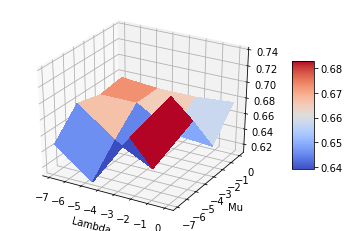

In [8]:
# credit: https://matplotlib.org/stable/gallery/mplot3d/surface3d.html

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.log(lmbd_range) #np.tile(np.log(lmbd_range), (4, 1))
Y = np.log(mu_range)
X, Y = np.meshgrid(X, Y)
Z = CVErrors

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('Lambda')
ax.set_ylabel('Mu')

plt.show()

# error higher since individual parameter combinations might be unequally beneficial for each of the five folds

## Plot training errors

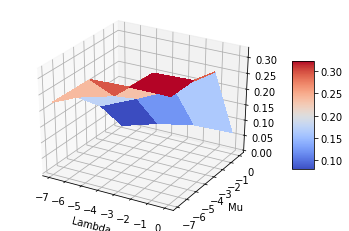

In [9]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.log(lmbd_range)
Y = np.log(mu_range)
X, Y = np.meshgrid(X, Y)
Z = TrainErrors

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('Lambda')
ax.set_ylabel('Mu')

plt.show()

## Plot test errors

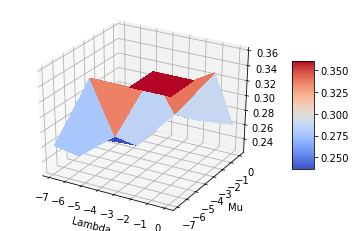

In [10]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.log(lmbd_range)
Y = np.log(mu_range)
X, Y = np.meshgrid(X, Y)
Z = TestErrors

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('Lambda')
ax.set_ylabel('Mu')

plt.show()

# Discussion

**Discuss the influence of λ and μ on all errors. How does the cross-validation error behave in comparison to the test error for different values of λ and μ?**

*Training Errors*
* An increase in μ leads to a decrease in the errors. This is probably due to the fact that as μ gets lower, the kernel output increases. Thus, similarities can be measured better and the classification works better.
* λ introduced regularization. As we are only interested in the training error here, we "want" the classifier to pick up idiosyncracies, which works best if λ is small.

*Test Errors*
* a λ in the middle of the range seems to minimize the loss on average. As we desire some regularization, this makes sense.
* We observe the following on average: The higher μ is, the higher should λ be for a low error. As μ increases, the kernel output decreases, which makes a higher lambda values necessary to keep the balance in the relationship (K+nλ1)α=Y

*Cross-validation Errors*
* a λ in the middle of the range seems to minimize the loss on average. As we desire some regularization, this makes sense.
* We observe the following on average: The higher μ is, the higher should λ be for a low error. As μ increases, the kernel output decreases, which makes a higher lambda values necessary to keep the balance in the relationship (K+nλ1)α=Y



***Magnitude of the errors***

As can be seen above, the CV-errors are considerably higher than the training and test errors. This might be caused by the low number of data points in the validations sets compared to the training and especially the test set. 